### **1.1 Install Dependencies**

In [175]:
!pip install tensorflow opencv-python matplotlib

### **1.2 Import Dependencies**

In [176]:
# Import Standard Dependencies
import cv2   #import opencv
import os   #operating system library
import random
import numpy as np
from matplotlib import pyplot as plt

In [177]:
# import tensorflow dependencies- Functional API
# Model= allows you to define and structure your neural network.
# Layer= The base class for all layers in Keras.
# Conv2D= This layer performs 2D convolution
# Dense= Fully Connected Layer
# Flatten= All the previous information is flatten down. Pass CNN data to a dense network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense,MaxPooling2D, Input, Flatten
import tensorflow as tf

### **1.3 Set GPU Growth**

In [178]:
#Avoid Out of Memory error by setting GPY Memory consumption growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [179]:
gpus

[]

 ### **1.4 Create Folder Strcture**

In [180]:
#Positive Images: Pictures containing the specific object or face the model should recognize.
#Negative Images: Pictures containing anything other than the target object or face.
#Anchor Images: Reference images used for comparison to determine similarity with other images.

In [181]:
 #Setup paths
 POS_PATH= os.path.join('data','positive')
 NEG_PATH=os.path.join('data','negative')
 ANC_PATH=os.path.join('data','anchor')


In [182]:
# Make the directories
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

# **2. Collecting Positives and Anchors**

### **2.1 Labelled Dataset in the Wild Dataset is imported an moved to negative folder**

In [183]:
!pip install opendatasets

In [184]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jessicali9530/lfw-dataset")

Skipping, found downloaded files in ".\lfw-dataset" (use force=True to force download)


In [185]:
# Move LFW images to the following repistory data/ngative
#for directory in os.listdir('lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'):
#    for file in os.listdir(os.path.join('lfw-dataset/lfw-deepfunneled/lfw-deepfunneled', directory)):
#        EX_PATH= os.path.join('lfw-dataset/lfw-deepfunneled/lfw-deepfunneled',directory,file)
#        NEW_PATH= os.path.join(NEG_PATH,file)
#        os.replace(EX_PATH,NEW_PATH)

### **2.2 Collect Positive and Anchor Classes**

In [186]:
#Import uuid library to generate unique image names
import uuid

In [187]:
uuid.uuid1()

UUID('d31890c4-2b33-11f0-b15c-c4236094bb04')

In [188]:
#Establish a connection to the webcam
cap=cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame=cap.read()

  #Cut down frame to 250x250px
  frame= frame[120:120+250,200:200+250, :]

  #Collect Anchors
  if cv2.waitKey(1) & 0XFF == ord('a'):
      #create the unique file path
      imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
      #write out the anchor image
      cv2.imwrite(imgname,frame)
 
  #Collect positives
  if cv2.waitKey(1) & 0XFF == ord('p'):
      #create the unique file path
      imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
      #write out the anchor image
      cv2.imwrite(imgname,frame)
  #Show image back to the screen
  cv2.imshow('Image Collection',frame)

  #Breaking Gracefully
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break

#Relese the webcam
cap.release()
      
#Close the image show frame
cv2.destroyAllWindows()


# **3. Load and Preprocess Images**

### **3.1 Get Image Directories**

In [189]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)

In [190]:
dir_test=anchor.as_numpy_iterator()

In [191]:
print(dir_test.next())

b'data\\anchor\\1db517ec-2a9b-11f0-990f-005056c00008.jpg'


### **3.2 Preprocessing scale and resize**

In [225]:
def preprocess(file_path):

    #Read in image from file path
    byte_img = tf.io.read_file(file_path)

    #Load in the image
    img = tf.io.decode_jpeg(byte_img)

    #Preprocessing steps-resizing the image to be 100x100x3
    img = tf.image.resize(img,(100,100))
    
    #Scale image to be between 0 and 1
    img = img/255.0
    
    #Return image
    return img

In [226]:
preprocess('data\\anchor\\f1039b98-2a9a-11f0-aa70-005056c00008.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.5227941 , 0.46495098, 0.3718137 ],
        [0.5372549 , 0.46519607, 0.3855392 ],
        [0.57009804, 0.4715686 , 0.4110294 ],
        ...,
        [0.59338236, 0.58259803, 0.5022059 ],
        [0.60784316, 0.5882353 , 0.5137255 ],
        [0.60490197, 0.5852941 , 0.50686276]],

       [[0.53112745, 0.45367646, 0.39681372],
        [0.55196077, 0.4629902 , 0.41004902],
        [0.5757353 , 0.4742647 , 0.4245098 ],
        ...,
        [0.5990196 , 0.5919118 , 0.51029414],
        [0.6102941 , 0.59583336, 0.5142157 ],
        [0.6066176 , 0.5870098 , 0.5007353 ]],

       [[0.54534316, 0.44240198, 0.4120098 ],
        [0.5627451 , 0.4509804 , 0.42303923],
        [0.5852941 , 0.47058824, 0.43235293],
        ...,
        [0.592402  , 0.5879902 , 0.5142157 ],
        [0.592402  , 0.5852941 , 0.5029412 ],
        [0.5990196 , 0.57941175, 0.49313724]],

       ...,

       [[0.50808823, 0.4492647 , 0.4237745 ],
        [0.48

In [227]:
img=preprocess('data\\anchor\\f1039b98-2a9a-11f0-aa70-005056c00008.jpg')

In [228]:
img.numpy().min()

np.float32(0.11176471)

In [229]:
img.numpy().max()

np.float32(0.7120098)

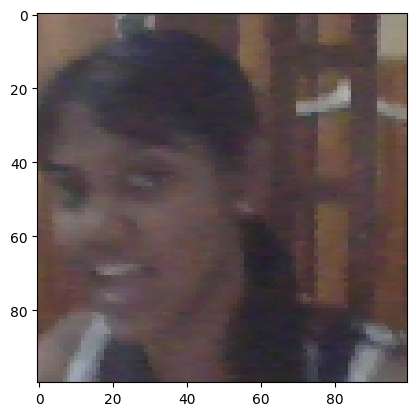

In [230]:
plt.imshow(img)

### **3.3 Create Labelled Dataset**

In [231]:
# (anchor,positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [232]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [233]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [234]:
samples = data.as_numpy_iterator()

In [235]:
exampple=samples.next()

In [236]:
exampple

(b'data\\anchor\\0a5079c8-2a96-11f0-beae-005056c00008.jpg',
 b'data\\positive\\a078777c-2a99-11f0-a099-005056c00008.jpg',
 np.float32(1.0))

### **3.3 Build Train and Test Partition**

In [237]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [238]:
 res =preprocess_twin(*exampple)

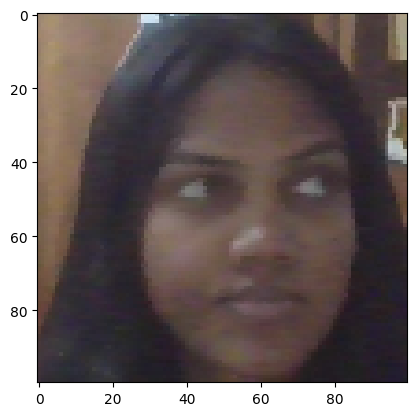

In [239]:
plt.imshow(res[0])


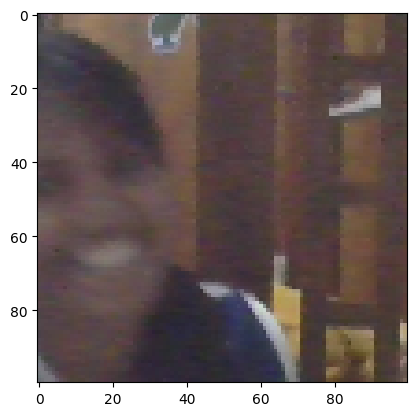

In [240]:
plt.imshow(res[1])

In [241]:
res[2]

np.float32(1.0)

In [242]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)


In [243]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [244]:
samples = data.as_numpy_iterator()

In [248]:
len(samples.next())

3

In [249]:
samp = samples.next()

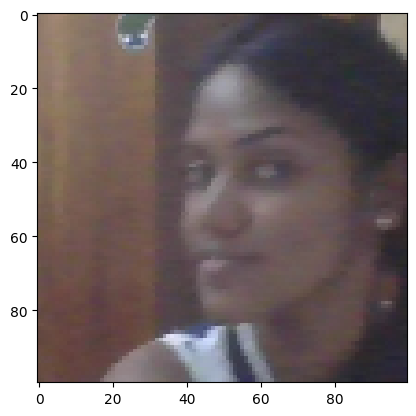

In [250]:
plt.imshow(samp[0])

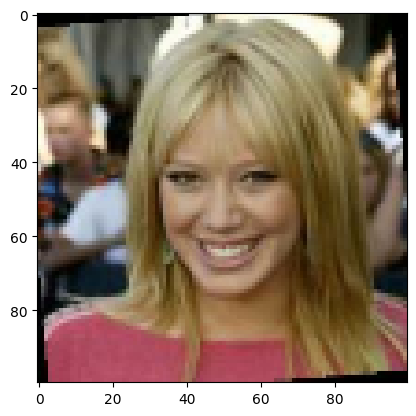

In [251]:
plt.imshow(samp[1])

In [252]:
samp[2]

np.float32(0.0)

In [253]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [254]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [255]:
train_samples = train_data.as_numpy_iterator()

In [256]:
train_sample = train_samples.next()

In [257]:
len(train_sample[0])

16

In [258]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### **4. Model Engineering**

### **4.1 Build Embedding Layer**

In [259]:
inp = Input(shape=(100,100,3), name='input_image')

In [260]:
inp

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=False, ragged=False, name=input_image>

In [261]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [262]:
c1

<KerasTensor shape=(None, 91, 91, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_27>

In [263]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [264]:
m1

<KerasTensor shape=(None, 46, 46, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_28>

In [265]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [266]:
c2

<KerasTensor shape=(None, 40, 40, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_29>

In [267]:
m2

<KerasTensor shape=(None, 20, 20, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_30>

In [268]:
m2

<KerasTensor shape=(None, 20, 20, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_30>

In [269]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [270]:
c3

<KerasTensor shape=(None, 17, 17, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_31>

In [271]:
m3

<KerasTensor shape=(None, 9, 9, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_32>

In [272]:
m3

<KerasTensor shape=(None, 9, 9, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_32>

In [273]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [274]:
c4

<KerasTensor shape=(None, 6, 6, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_33>

In [275]:
 f1

<KerasTensor shape=(None, 9216), dtype=float32, sparse=False, ragged=False, name=keras_tensor_34>

In [276]:
d1

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_35>

In [277]:
mod = Model(inputs=[inp], outputs=d1, name='embedding')

In [278]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [279]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=d1, name='embedding')

In [280]:
embedding = make_embedding()

In [281]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### **4.2 Build Distance Layer**

In [282]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [283]:
l1 = L1Dist()

### **4.3 Make Siamese Model**

In [284]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [285]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)


In [286]:
inp_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_45>

In [287]:
val_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_46>

In [288]:
siamese_layer = L1Dist()

In [289]:
siamese_layer(inp_embedding,val_embedding)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_47>

In [290]:
distances = siamese_layer(inp_embedding, val_embedding)


In [291]:
distances

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_48>

In [292]:
    classifier = Dense(1, activation='sigmoid')(distances)

In [293]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_49>

In [294]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [295]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_4 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_4[1][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [296]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [297]:
siamese_model = make_siamese_model()

In [298]:
siamese_model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_5 (L1Dist)            │ (None, 4096)              │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_5[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# **5. Training**

### **5.1 Setup Loss and Optimizer**

In [299]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [300]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### **5.2 Establish Checkpoints**

In [301]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### **5.3 Build Train Step Function**

In [302]:
test_batch=train_data.as_numpy_iterator()

In [303]:
batch_1=test_batch.next()

In [304]:
x=batch_1[:2]

In [305]:
np.array(x).shape

(2, 16, 100, 100, 3)

In [306]:
y=batch_1[2]

In [307]:
y

array([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.],
      dtype=float32)

In [308]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss


### **5.4 Build Training Loop**

In [309]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [310]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### **5.5 Train the model**

In [311]:
EPOCHS = 50

In [312]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 Epoch 15/50
27/27 ━━━━━━

### **6. Evaluate Model**

6.1 Import Metrics

In [143]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

6.2 Make Predictions

In [144]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [145]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


array([[4.7686581e-06],
       [1.0000000e+00],
       [9.7015443e-05],
       [9.9983591e-01],
       [8.2740502e-04],
       [9.9646252e-01],
       [1.4265720e-07],
       [6.8783230e-08],
       [2.4440699e-06],
       [9.9999940e-01],
       [1.0741631e-05],
       [1.2932464e-09],
       [5.8357116e-05],
       [1.0000000e+00],
       [5.7054376e-06],
       [5.8624853e-05]], dtype=float32)

In [146]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]

In [147]:
y_true

array([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

6.3 Calculate Metrics

In [148]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [149]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

6.4 Visualize Results

In [154]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[])

# Renders cleanly
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1827243056.py, line 10)